![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
!pip install geonamescache

In [3]:
import re
from datetime import datetime, timedelta

import geonamescache
gc = geonamescache.GeonamesCache()

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [6]:
# DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [10]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [11]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [15]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
14215,id_6223,Paris,"['Chinese', 'Japanese', 'Asian']",6224.0,$,111.0,"[['Not bad, decent sushi but busy venue', 'New...",/Restaurant_Review-g187147-d1950242-Reviews-Og...,d1950242,1,3.5
20856,id_1811,Prague,"['European', 'Czech']",1814.0,$,5.0,"[['very nice place outside', 'Great location, ...",/Restaurant_Review-g274707-d7123352-Reviews-Za...,d7123352,1,5.0
14558,id_893,Oslo,NaN,894.0,NaN,5.0,"[['Good place for refreshments', 'good for a q...",/Restaurant_Review-g190479-d8749259-Reviews-Tu...,d8749259,1,4.0
10769,id_7470,Madrid,"['Chinese', 'Fast Food', 'Vegetarian Friendly']",7476.0,$,5.0,"[['Nice location for a quick bite', 'Strange m...",/Restaurant_Review-g187514-d11931682-Reviews-T...,d11931682,1,4.0
12007,id_866,Milan,['Mediterranean'],868.0,$$ - $$$,232.0,"[['Very nice surprise', 'Excellent food and se...",/Restaurant_Review-g187849-d5308404-Reviews-Ga...,d5308404,1,4.0


In [16]:
df.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

###  Обработка признаков


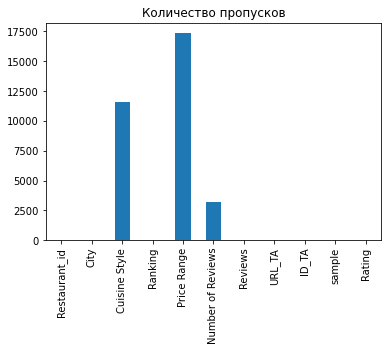

In [17]:
df.isna().sum().plot(kind='bar',title='Количество пропусков')

# Признаки Cuisine Style, Price Range, Number of Reviews  содержат много пропусков.
# Заполним их и создадим новые признаки,"is_NAN" , которые будут говорить о наличии пропуска)

In [18]:
df['Cuisine Style_NAN'] = df['Cuisine Style'].isna().astype('uint8')
df['Price Range_NAN'] = df['Price Range'].isna().astype('uint8')
df['Number of Reviews_NAN'] = df['Number of Reviews'].isna().astype('uint8')

# **Restaurant_id**

In [19]:
df.loc[:,['Restaurant_id']]

,Restaurant_id
0,id_0
1,id_1
2,id_2
3,id_3
4,id_4
...,...
49995,id_499
49996,id_6340
49997,id_1649
49998,id_640


# Признак не содержит полезной информации, удалим его

In [20]:
df = df.drop(['Restaurant_id'],axis=1)

# City

In [21]:
def get_population(city):
    total_info = gc.get_cities_by_name(city)
    if total_info != []:
        total_info = gc.get_cities_by_name(city)[0]
        city_code = next(iter(total_info.keys()))
        population = total_info[city_code]['population']
        return population

    else:
        if city == 'Oporto':
            population = 214349
        elif city == 'Zurich':
            population = 402762
        elif city == 'Krakow':
            population = 779115
        return population

In [22]:
country = {
    'Paris': 'France',
    'Hamburg': 'Germany',
    'Rome': 'Italy',
    'London': 'UK',
    'Milan': 'Italy',
    'Madrid': 'Spain',
    'Oslo': 'Norway',
    'Stockholm': 'Sweden',
    'Krakow': 'Poland',
    'Lyon': 'Paris',
    'Lisbon': 'Portugal',
    'Edinburgh': 'UK',
    'Vienna': 'Austria',
    'Warsaw': 'Poland',
    'Amsterdam': 'Netherlands',
    'Budapest': 'Hungary',
    'Helsinki': 'Finland',
    'Zurich': 'Switzerland',
    'Luxembourg': 'Luxembourg',
    'Berlin': 'Germany',
    'Prague': 'Czechia',
    'Munich': 'Germany',
    'Bratislava': 'Slovakia',
    'Brussels': 'Belgium',
    'Ljubljana': 'Slovenia',
    'Copenhagen': 'Denmark',
    'Oporto': 'Portugal',
    'Barcelona': 'Spain',
    'Geneva': 'Switzerland',
    'Athens': 'Greece',
    'Dublin': 'Ireland'
}

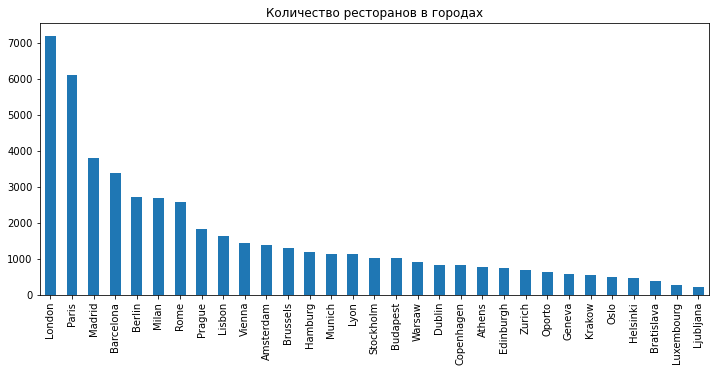

In [23]:
plt.figure(figsize=(12,5))
df.City.value_counts().plot(kind='bar', title='Количество ресторанов в городах')

In [24]:
city_count = dict(df['City'].value_counts())
df['rest_count'] = df['City'].map(city_count)

In [25]:
df['population'] = df['City'].apply(lambda x: get_population(x))

In [26]:
df['country'] = df['City'].map(country)

In [27]:
df['rest_per_people'] = df['rest_count'] / df['population']

In [28]:
capital_list = ['London', 'Paris', 'Stockholm', 'Madrid', 'Berlin',
                'Rome', 'Prague', 'Lisbon', 'Vienna', 'Amsterdam', 
                'Budapest', 'Warsaw', 'Dublin', 'Copenhagen',
                'Athens', 'Edinburgh', 'Oslo', 'Helsinki', 
                'Bratislava', 'Ljubljana', 'Brussels', 'Luxembourg']

df['is_capital'] = df['City'].apply(lambda x: 1 if x in capital_list else 0)

In [29]:
df.columns

Index(['City', 'Cuisine Style', 'Ranking', 'Price Range', 'Number of Reviews',
       'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'Cuisine Style_NAN',
       'Price Range_NAN', 'Number of Reviews_NAN', 'rest_count', 'population',
       'country', 'rest_per_people', 'is_capital'],
      dtype='object')

# Вывод 
### На практике признаки "столица или нет" и "отношение кол-ва ресторанов к кол-ву людей в городе" результат не дали. В итоговом решении учтены не будут.

# Cuisine Style

In [30]:
# Получаем кол-во редких кухонь
def get_rare_cuisines_count(cuis):
    x = 0
    for i in rare_cuisins_list:
        if i in cuis:
            x += 1
    return x

In [31]:
# Получаем кол-во часто встречающихся кухонь
def get_common_cuisines_count(cuis):
    x = 0
    for i in common_cuisins_list:
        if i in cuis:
            x += 1
    return x

In [32]:
def fill_ones(x):
    if cus in x:
        return 1
    return 0

In [33]:
def is_rare(cuis):
    for i in cuis:
        if i in rare_cuisins_list:
            return 1
        else:
            return 0
    
    
    
def is_common(cuis):
    for i in cuis:
        if i in common_cuisins_list:
            return 1
        else:
            return 0

In [34]:
# Заполняем пустые значения "Other"
df['Cuisine Style'].fillna("['Other']", inplace=True)

In [35]:
# Преобразуем строчные значения в списки
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: eval(x))

In [36]:
# Количество кухонь в ресторане
df['count_cuisines'] = df['Cuisine Style'].apply(lambda x: len(x))

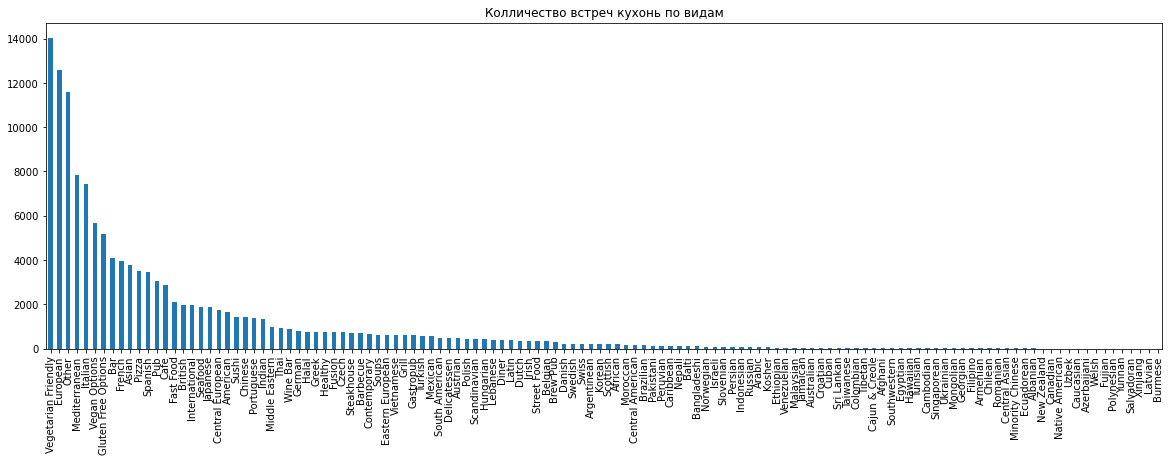

In [37]:
plt.figure(figsize=(20, 6))
pd.Series.explode(df['Cuisine Style']).value_counts().plot(
    kind='bar', title='Колличество встреч кухонь по видам')

### Создадим два признака "is_rare", "rare_cuisines_count" со значениями 1 и 0 в первом, в зависимости от того, есть ли среди кухонь ресторана редкие или часто встречающиеся, и с количеством редких кухонь во втором. За критерий редкости возьмем медиальное значение этого параметра.

In [38]:
# Взорвали столбец "Cuisine Style"
exploded_cuisin_list = pd.Series.explode(df['Cuisine Style']).value_counts()

In [39]:
# Список кухонь, количество встреч которых, мы наблюдаем реже чем медиальное значение общего количества встреч кухонь.
rare_cuisins_list = exploded_cuisin_list.loc[exploded_cuisin_list < round(
    exploded_cuisin_list.median())].index.tolist()

In [40]:
# Список кухонь, количество встреч которых, мы наблюдаем чаще чем медиальное значение общего количества встреч кухонь.
common_cuisins_list = exploded_cuisin_list.loc[exploded_cuisin_list > round(
    exploded_cuisin_list.median())].index.tolist()

In [41]:
df['rare_cuisines_count'] = df['Cuisine Style'].apply(get_rare_cuisines_count)
    

In [42]:
# Признаки с часто встречающимися кухнями результат не дали
# df['common_cuisines_count'] = df['Cuisine Style'].apply(get_common_cuisines_count)
# df['is_common'] = df['Cuisine Style'].apply(is_common)

In [43]:
df['is_rare'] = df['Cuisine Style'].apply(is_rare)

In [44]:
cuisines = pd.Series.explode(df['Cuisine Style']).unique()

# Ranking

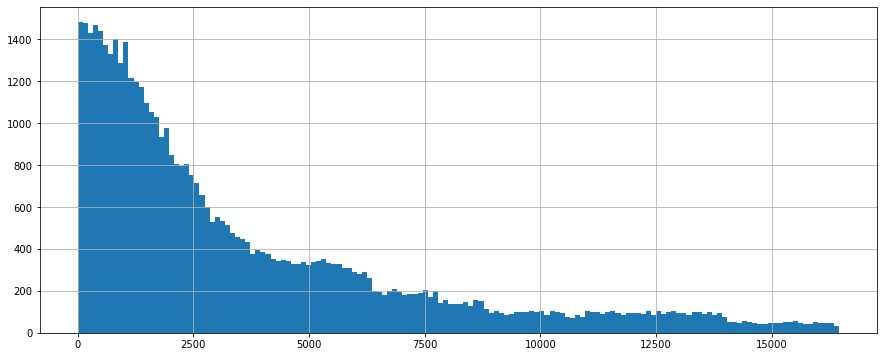

In [45]:
plt.rcParams['figure.figsize'] = (15,6)
df.Ranking.hist(bins=150)

# Price Range

In [46]:
df.isna().sum()

City                         0
Cuisine Style                0
Ranking                      0
Price Range              17361
Number of Reviews         3200
Reviews                      2
URL_TA                       0
ID_TA                        0
sample                       0
Rating                       0
Cuisine Style_NAN            0
Price Range_NAN              0
Number of Reviews_NAN        0
rest_count                   0
population                   0
country                      0
rest_per_people              0
is_capital                   0
count_cuisines               0
rare_cuisines_count          0
is_rare                      0
dtype: int64

In [47]:
df['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [48]:
price_dict = {'$': 1,
              '$$ - $$$': 2,
              '$$$$': 3}

In [49]:
df['Price Range'] = df['Price Range'].map(price_dict)

# Заполним пропуски наиболее часто встречающимся значением 2

In [50]:
df['Price Range'].fillna(2, inplace=True)

# Number of Reviews

In [51]:
df['Number of Reviews'].isna().sum()

3200

In [52]:
df['Number of Reviews'].fillna(0, inplace=True)

In [53]:
df['Number of Reviews'].value_counts()

0.0       3200
2.0       2403
3.0       2042
4.0       1707
5.0       1471
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number of Reviews, Length: 1574, dtype: int64

# Reviews

Столбец строковый, содержит информацию с отзывами и датами отзывов. Много незаполненных значений формата "[[], []]". 

In [54]:
def get_date(s: 'str'):
    fin = []
    tmp = re.findall('\d\d/\d\d/\d{4}', s)
    if [] not in tmp:
        for i in tmp:
            dt_tmp = datetime.strptime(i, '%m/%d/%Y')
            fin.append(dt_tmp)

        return fin
    else:
        return [0, 0]

In [55]:
def get_delta_date(x):    
    if len(x) > 1:
        return abs((x[0]-x[1]).days)
    else:
        return abs((x[0]-x[0]).days)

In [56]:
df['Reviews'].fillna('[[], []]',inplace=True)

In [57]:
df['date_review'] = df['Reviews'].apply(lambda x: get_date(x))

In [58]:
# Найдем дату первого отзыва по всем ресторанам и заполним ей пустые значения
dates = []
for i in df.date_review:
    if i != None:
        for j in i:
            dates.append(j)
min_date = min(dates)

In [59]:
df['date_review'] = df['date_review'].apply(lambda x: [min_date,min_date] if x ==[] else x)

In [60]:
df['date_review'].apply(lambda x: [min_date,min_date] if x ==[] else x)

0        [2004-04-21 00:00:00, 2004-04-21 00:00:00]
1        [2017-12-05 00:00:00, 2017-10-29 00:00:00]
2        [2017-12-28 00:00:00, 2017-12-06 00:00:00]
3        [2017-12-06 00:00:00, 2017-11-22 00:00:00]
4        [2018-02-08 00:00:00, 2018-01-24 00:00:00]
                            ...                    
49995    [2017-12-16 00:00:00, 2017-11-12 00:00:00]
49996    [2017-12-21 00:00:00, 2017-12-12 00:00:00]
49997    [2016-11-03 00:00:00, 2008-04-12 00:00:00]
49998    [2017-07-11 00:00:00, 2017-06-18 00:00:00]
49999    [2016-01-31 00:00:00, 2012-07-04 00:00:00]
Name: date_review, Length: 50000, dtype: object

In [61]:
# Берем первый элемент из списка дат в каждой строке, 
# так как он соответствует более позднему комментарию
df['last_review_date'] = df['date_review'].apply(lambda x: x[0])

In [62]:
# Берем первый элемент из списка дат в каждой строке, 
# если количество дат отзывов меньше двух. Иначе второй,так как может быть 3 даты отзывов
df['prelast_review_date'] = df['date_review'].apply(
    lambda x: x[0] if len(x) < 2 else x[1])

In [63]:
df.sample(5)

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,population,country,rest_per_people,is_capital,count_cuisines,rare_cuisines_count,is_rare,date_review,last_review_date,prelast_review_date
45357,Athens,"[Mediterranean, Greek, Turkish]",1542.0,1.0,16.0,"[['small & cute', 'Real Artist\'s tavern in th...",/Restaurant_Review-g189400-d7742958-Reviews-Ef...,d7742958,1,3.5,...,664046,Greece,0.001169,1,3,0,0,"[2017-10-11 00:00:00, 2017-04-18 00:00:00]",2017-10-11,2017-04-18
22961,Oslo,"[Italian, Pizza, European, Vegetarian Friendly...",311.0,2.0,43.0,"[['On superb - or slightly off...', 'Small Pla...",/Restaurant_Review-g190479-d7194514-Reviews-Ca...,d7194514,1,4.0,...,580000,Norway,0.000841,1,5,0,0,"[2017-11-04 00:00:00, 2017-03-30 00:00:00]",2017-11-04,2017-03-30
20882,Lisbon,[Vegetarian Friendly],1781.0,1.0,28.0,"[['Good yet a little bit outdated', 'The food ...",/Restaurant_Review-g189158-d697297-Reviews-Esp...,d697297,1,4.0,...,517802,Portugal,0.003181,1,1,0,0,"[2016-05-05 00:00:00, 2015-11-23 00:00:00]",2016-05-05,2015-11-23
3218,Madrid,"[Mediterranean, Spanish, Vegetarian Friendly, ...",533.0,2.0,139.0,"[['Great food.', 'Date night ritual'], ['11/16...",/Restaurant_Review-g187514-d10730909-Reviews-M...,d10730909,0,0.0,...,50437,Spain,0.075599,1,4,0,0,"[2017-11-16 00:00:00, 2017-10-11 00:00:00]",2017-11-16,2017-10-11
26620,Milan,"[Japanese, Sushi, Fusion, Vegetarian Friendly]",884.0,2.0,465.0,"[['Dinner with friend', 'Disappointing'], ['09...",/Restaurant_Review-g187849-d4946126-Reviews-Fu...,d4946126,1,4.0,...,1236837,Italy,0.002178,0,4,0,0,"[2017-09-22 00:00:00, 2017-05-01 00:00:00]",2017-09-22,2017-05-01


Признак с количеством дней между последними отзывами "delta_date"

In [64]:
df['delta_date'] = df['date_review'].apply(lambda x: get_delta_date(x))

In [65]:
df['delta_date'].isna().sum()

0

Признак с количеством дней между последним оставленным отзывом и сегодняшней датой

In [66]:
today = datetime.now()
df['delta_current_date'] = df['last_review_date'].apply(lambda x: (today - x).days)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

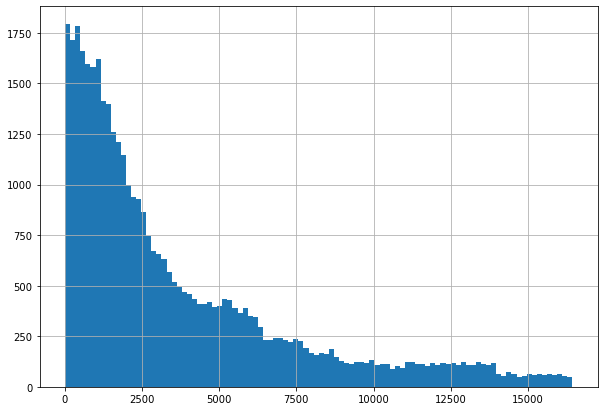

In [67]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

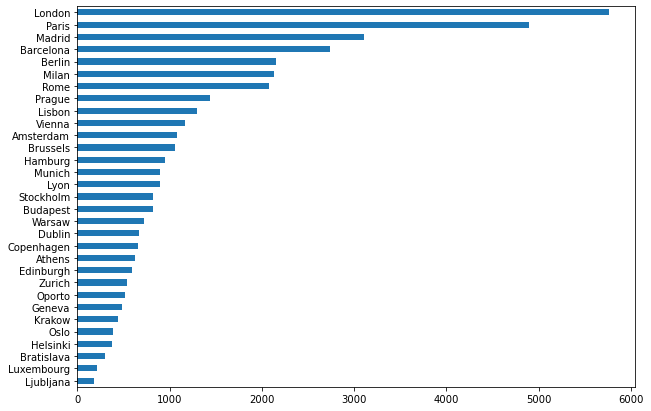

In [68]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

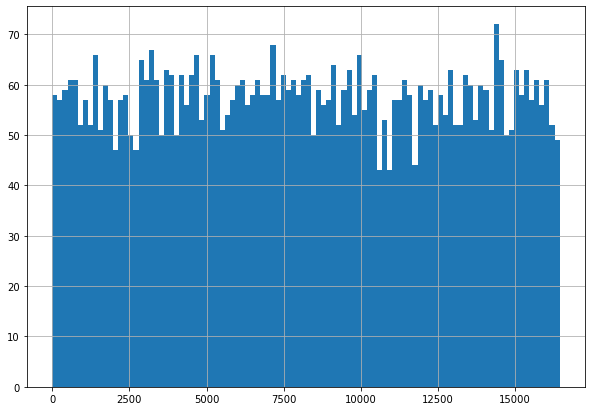

In [69]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

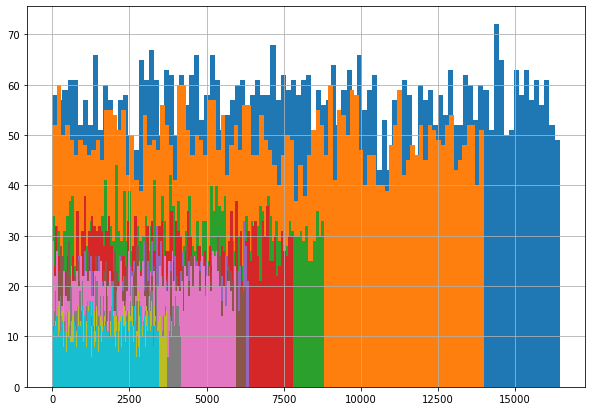

In [70]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

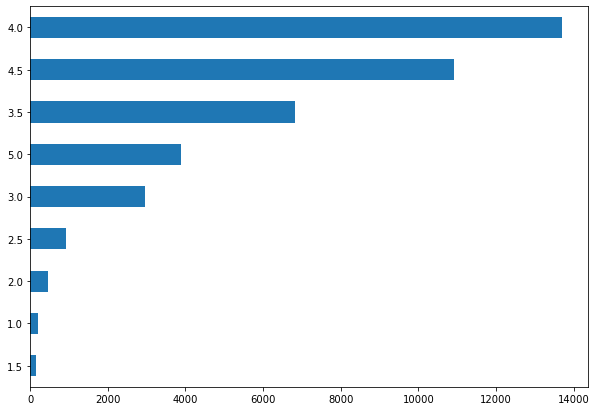

In [71]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

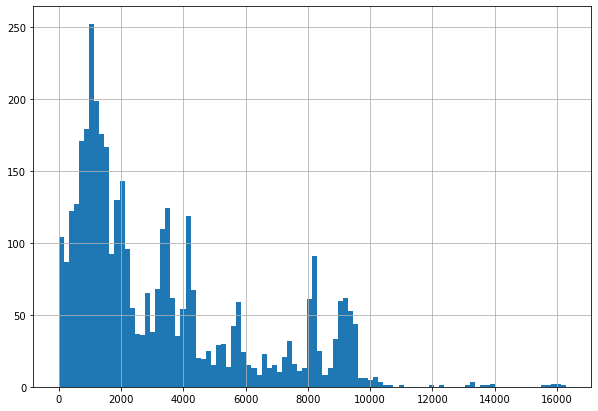

In [72]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

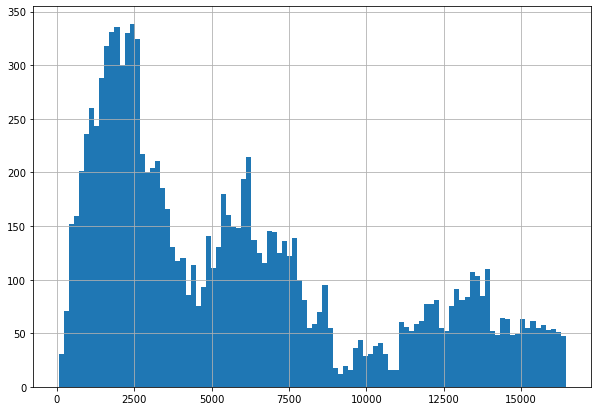

In [73]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

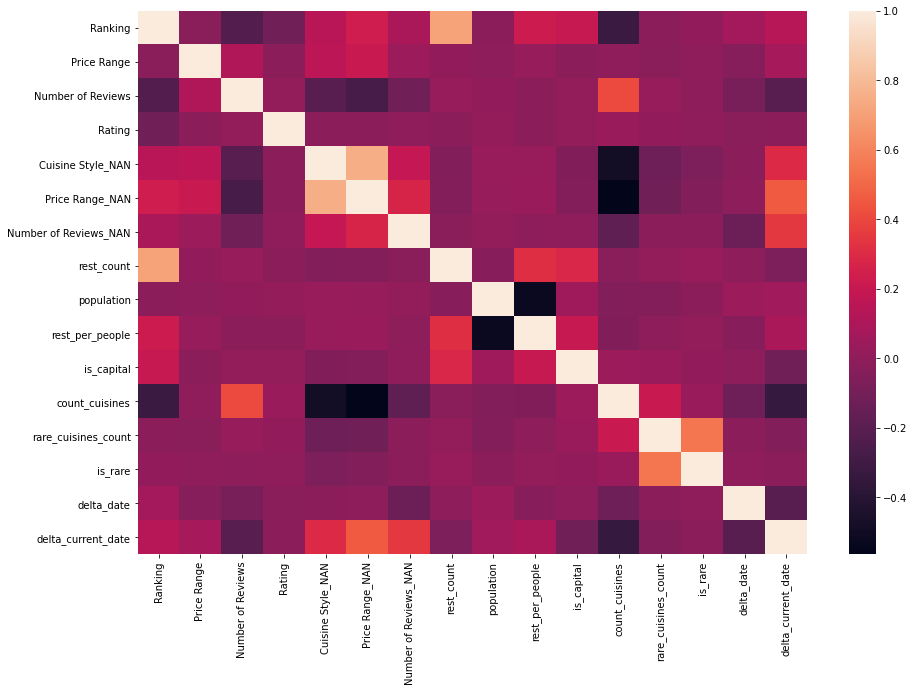

In [74]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['sample'], axis=1).corr(),)

## Изучив таблицу коррелиции признаков, убираем сильно коррелириющие признаки "is_common", "common_cuisines_count", 

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Dummies
### Добавим Dummies в конце, для удобства отслеживания эффективности добавленных признаков

In [75]:
dummy_city = df.City.str.get_dummies()
df = pd.concat([df,dummy_city],axis=1)


In [76]:
for cus in cuisines:
    df[cus] = df['Cuisine Style'].apply(fill_ones)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [77]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [78]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 0. Функции ##############################################################
    # Получаем информацию из сторонней библиотеки
    def get_population(city):
        total_info = gc.get_cities_by_name(city)
        if total_info != []:
            total_info = gc.get_cities_by_name(city)[0]
            city_code = next(iter(total_info.keys()))
            population = total_info[city_code]['population']
            return population
        else:
            if city == 'Oporto':
                population = 214349
            elif city == 'Zurich':
                population = 402762
            elif city == 'Krakow':
                population = 779115
            return population

    # Получаем кол-во редких кухонь
    def get_rare_cuisines_count(cuis):
        x = 0
        for i in rare_cuisins_list:
            if i in cuis:
                x += 1
        return x
    
    

    # Функция энкодинга кухонь
    def fill_ones(x):
        if cus in x:
            return 1
        return 0
    
    
    
    
    # Функция присваивающая 1, если кухня среди редких, иначе- 0
    def is_rare(cuis):
        for i in cuis:
            if i in rare_cuisins_list:
                return 1
            else:
                return 0
            
            

    # Получаем дату из отзывов
    def get_date(s: 'str'):
        fin = []
        tmp = re.findall('\d\d/\d\d/\d{4}', s)
        if [] not in tmp:
            for i in tmp:
                dt_tmp = datetime.strptime(i, '%m/%d/%Y')
                fin.append(dt_tmp)
            return fin
        else:
            return [0, 0]

    # Получаем разницу между отзывами в днях
    def get_delta_date(x):
        if len(x) > 1:
            return abs((x[0]-x[1]).days)
        else:
            return abs((x[0]-x[0]).days)
        
        
    # Полярность отзыва
    def polarity_rev(x):
        if '[]' not in x:
            text = x
            sent = TextBlob(text)
            polarity = sent.sentiment.polarity
            return polarity
        else:
            return None

    # ################### 1. Предобработка ##############################################################
    # убираем ненужные для модели признаки. 'URL_TA' убрали, так как парсить я не умею
    df_output.drop(['Restaurant_id', 'ID_TA', 'URL_TA'], axis=1, inplace=True)
    df_output['Cuisine Style_NAN'] = df_output['Cuisine Style'].isna().astype(
        'uint8')
    df_output['Price Range_NAN'] = df_output['Price Range'].isna().astype('uint8')
    
    # Список кухонь
    cities = df_output['City'].unique()
    
    # Словарь город:кол-во ресторанов
    city_count = dict(df_output['City'].value_counts())
    
    # Словарь город:страна
    country = {
        'Paris': 'France',
        'Hamburg': 'Germany',
        'Rome': 'Italy',
        'London': 'UK',
        'Milan': 'Italy',
        'Madrid': 'Spain',
        'Oslo': 'Norway',
        'Stockholm': 'Sweden',
        'Krakow': 'Poland',
        'Lyon': 'Paris',
        'Lisbon': 'Portugal',
        'Edinburgh': 'UK',
        'Vienna': 'Austria',
        'Warsaw': 'Poland',
        'Amsterdam': 'Netherlands',
        'Budapest': 'Hungary',
        'Helsinki': 'Finland',
        'Zurich': 'Switzerland',
        'Luxembourg': 'Luxembourg',
        'Berlin': 'Germany',
        'Prague': 'Czechia',
        'Munich': 'Germany',
        'Bratislava': 'Slovakia',
        'Brussels': 'Belgium',
        'Ljubljana': 'Slovenia',
        'Copenhagen': 'Denmark',
        'Oporto': 'Portugal',
        'Barcelona': 'Spain',
        'Geneva': 'Switzerland',
        'Athens': 'Greece',
        'Dublin': 'Ireland'
    }
    # Список столиц

    # ################### 2. NAN ##############################################################

    df_output['Number of Reviews'].fillna(0, inplace=True)
    df_output['Reviews'].fillna('[[], []]', inplace=True)
    df_output['Cuisine Style'].fillna("['Other']", inplace=True)
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(
        lambda x: eval(x))

    # Взорвали столбец "Cuisine Style"
    exploded_cuisin_list = pd.Series.explode(
        df_output['Cuisine Style']).value_counts()

    # Список кухонь, количество встреч которых, мы наблюдаем реже чем медиальное значение общего количества встреч кухонь.
    rare_cuisins_list = exploded_cuisin_list.loc[exploded_cuisin_list < round(
        exploded_cuisin_list.median())].index.tolist()

    # Список кухонь
    cuisines = pd.Series.explode(df['Cuisine Style']).unique()

    # Словарь ценового диапазона
    price_dict = {'$': 1,
                  '$$ - $$$': 2,
                  '$$$$': 3}

    # Заменяем строковые значения числовыми и заполняем пропуски наиболее часто встреяающимся значением
    df_output['Price Range'] = df_output['Price Range'].map(price_dict)
    df_output['Price Range'].fillna(2, inplace=True)

    # ################### 3. Encoding ##############################################################

    # City
    dummies = df_output.City.str.get_dummies()
    pd.concat([df_output, dummies], axis=1)

    # Cuisins
    for cus in cuisines:
        df_output[cus] = df_output['Cuisine Style'].apply(fill_ones)
    # ################### 4. Feature Engineering ####################################################

    # Количество кухонь в ресторане
    df_output['count_cuisines'] = df_output['Cuisine Style'].apply(
        lambda x: len(x))

    # Количество редких кухонь
    df_output['rare_cuisines_count'] = df_output['Cuisine Style'].apply(
        get_rare_cuisines_count)

    # Бинарный признак редкости кухни
    df_output['is_rare'] = df_output['Cuisine Style'].apply(is_rare)

    # Количество ресторанов в городе
    df_output['rest_count'] = df_output['City'].map(city_count)

    # Количество людей в городе
    df_output['population'] = df_output['City'].apply(
        lambda x: get_population(x))

    # Даты отзывов
    df_output['date_review'] = df_output['Reviews'].apply(
        lambda x: get_date(x))

    # Дата первого отзыва по всем отзывам
    min_date = pd.Series.explode(df_output['date_review']).min()

    # Заполнение пустых значений датой первого отзыва
    df_output['date_review'] = df_output['date_review'].apply(
        lambda x: [min_date, min_date] if x == [] else x)

    # Берем первый элемент из списка дат в каждой строке, так как он соответствует более позднему комментарию
    df_output['last_review_date'] = df_output['date_review'].apply(
        lambda x: x[0])

    # Берем первый элемент из списка дат в каждой строке, если количество дат отзывов меньше двух.
    # Иначе- второй,так как может быть 3 даты отзывов
    df_output['prelast_review_date'] = df_output['date_review'].apply(
        lambda x: x[0] if len(x) < 2 else x[1])

    # Признак количества дней между последними отзывами
    df_output['delta_date'] = df_output['date_review'].apply(
        lambda x: get_delta_date(x))

    # Признак количества дней между последним отзывом и сегодняшней датой
    today = datetime.now()
    df_output['delta_current_date'] = df_output['last_review_date'].apply(
        lambda x: (today - x).days)
        
    #  Признак полярности отзыва
    df_output['polarity_rev'] = df_output.Reviews.apply(lambda x: polarity_rev(x))
    df_output['polarity_rev'] = df_output['polarity_rev'].fillna(df_output.polarity_rev.mean())
    # ################### 5. Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [
        s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis=1, inplace=True)

    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [79]:
df_preproc = preproc_data(data)
df_preproc.drop(['last_review_date','prelast_review_date'], axis=1, inplace=True)

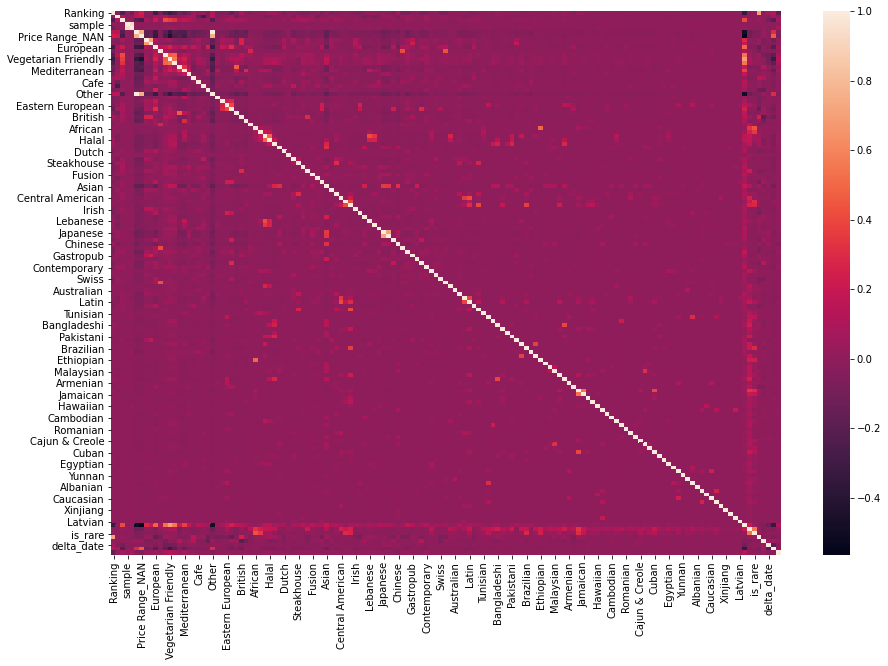

In [80]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df_preproc.corr(),)

In [81]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [82]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [83]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 140), (40000, 140), (40000, 139), (32000, 139), (8000, 139))

# Model 
Сам ML

In [84]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [85]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [86]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [87]:
# Видим разницу в том, что реальные рейтинги всегда кратны 0.5
# Напишем функцию соответствующей корректировки предсказанных рейтингов
def fine_rating_pred(rating_pred):
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

In [88]:
# Применим такое округление
for i in range(len(y_pred)):
    y_pred[i] = fine_rating_pred(y_pred[i])

In [89]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1731875


In [90]:
# pre 0.1731875
# best 0.1731875

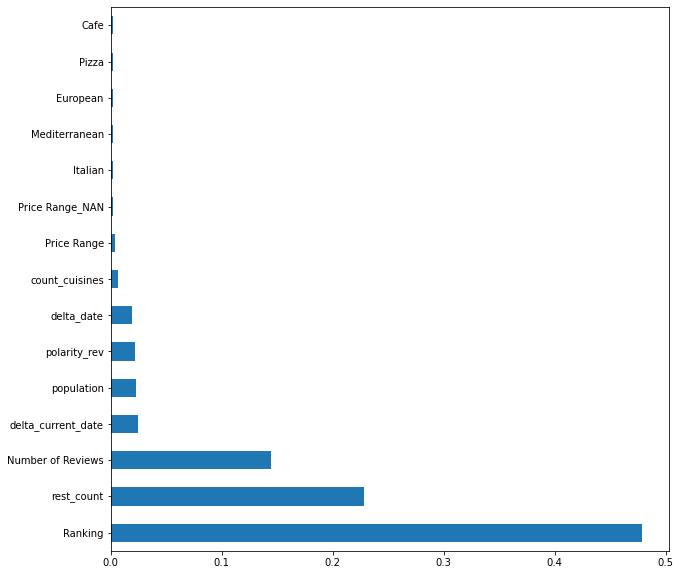

In [91]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [92]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Cuisine Style_NAN,Price Range_NAN,Bar,Pub,European,Scandinavian,...,Fujian,Latvian,count_cuisines,rare_cuisines_count,is_rare,rest_count,population,delta_date,delta_current_date,polarity_rev
8777,473.0,2.0,26.0,0.0,0,0,1,1,1,1,...,0,0,5,0,0,263,76684,151,1375,0.825000
7325,398.0,2.0,106.0,0.0,0,0,0,0,1,0,...,0,0,7,0,0,1816,1165581,6,1281,0.516667
5698,442.0,2.0,244.0,0.0,0,0,1,1,1,0,...,0,0,5,0,0,1372,741636,2,1217,0.600000
9883,487.0,1.0,22.0,0.0,0,0,0,0,0,0,...,0,0,1,0,0,1145,1260391,136,1257,0.866667
2587,3384.0,2.0,181.0,0.0,0,0,0,0,0,0,...,0,0,3,0,0,7193,346765,27,1194,0.800000
5824,10905.0,1.0,10.0,0.0,0,0,0,0,0,0,...,0,0,1,0,0,7193,346765,40,1687,0.666667
23,1255.0,2.0,51.0,0.0,0,0,0,0,0,0,...,0,0,3,0,0,1314,1019022,127,1276,0.700000
5696,11548.0,2.0,14.0,0.0,0,0,0,0,0,0,...,0,0,2,1,0,7193,346765,0,1325,0.378571
1658,3905.0,2.0,267.0,0.0,0,0,0,0,0,0,...,0,0,4,0,0,2589,2318895,117,1187,0.800000
8238,3515.0,2.0,288.0,0.0,0,0,0,0,0,0,...,0,0,2,0,0,2589,2318895,1417,1451,0.156250


In [93]:
test_data = test_data.drop(['Rating'], axis=1)

In [94]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [95]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [96]:
# Применим округление
for i in range(len(predict_submission)):
    predict_submission[i] = fine_rating_pred(predict_submission[i])

In [97]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [98]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
